# Radar Cross Section (RCS) Modeling

A common SSA question is then "What is the RCS of an object with a certain diameter?" Or put differently,  "What is the RCS of an object of a certain size as seen by a radar operating at this frequency?" We are also interested in knowing what size object could be detected if we know our radar can sense a certain RCS. To answer these we'll use NASA Size Estimation Module (SEM) outlined from [1]. See also [2] and [3] which use the same model. 

In practice we rarely know the "size" of an object since they are 3-dimensional and rarely something with a nice spherical shape. This is even worse for debris objects. So when we talk about size in the this document we will use the definition from [1]:

> "The characteristic length [size] of an object is defined as the average of the largest dimensions for an object measured along three orthogonal axes. The first axis was chosen to coincide with the largest dimension, the second axis to coincide with the largest dimension in plane orthogonal to the first axis, and the third axis to be orthogonal to the first two axes."

We want to calculate the RCS - but at it's simplest the RCS is a function of both the size of the object and the frequency of the radar that is trying to track it. Once we know the RCS, we can then start to figure out whether the radar could actually detect it by applying the standard radar link budget equations (out of scope for this document). 

The key question is what is the relative size comparison between the wavelength of the transmitted radar frequency and the size of the object you want to track. Following the definitions used in the NASA SEM we can say that when the wavelength $\lambda$ is much smaller than the size of the object that the radar is operating in the "Optical" region. If $\lambda$ is greater than the object size then it's operating in the "Rayleigh" region. Between these extremes it's in the "Mie Resonance" region. With that in mind we establish some convenient variables 

$$
\begin{align}
z & = \frac{\text{RCS}}{\lambda^2} \\
x & = \frac{\text{d}}{\lambda} \\
\lambda & = \text{wavelength} \\
d & = \text{diameter}
\end{align}
$$

and use them to define our operating curves.

$$
\begin{align}
x & = \sqrt{\frac{4z}{\pi}} & \text{ for }z>5 & \text{, Optical Region} \\
x & = \sqrt[6]{\frac{4z}{9\pi^5}} & \text{ for }z<0.03 & \text{, Rayleigh Region} \\
x & = g(z) & \text{ for }0.03 < z < 5 & \text{, Mie Resonance Region} \\
\end{align}
$$

where $g(z)$ is a piecewise continous approximation function. Note that $z$ in these equations is expressed in normal linear scale units, not dB. If we substitute these equations into each other we can see that when operating in the optical regime the RCS is independent of the wavelength and is simply the surface area of a sphere.

$$
\text{RCS} = \pi (d/2)
$$


In [23]:
# Standard imports
import numpy as np
import pandas as pd
import scipy.constants
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, LogLocator

# My custom code
import radar

%reload_ext autoreload
%autoreload 2

plt.rcParams.update({'font.family':'Gudea'})

With this model we can plot the normalized RCS against the normalized diameter and reproduce Fig. 3.2 (log scale) and 3.3 (dB scale) from [1] just to make sure we have things coded up properly.

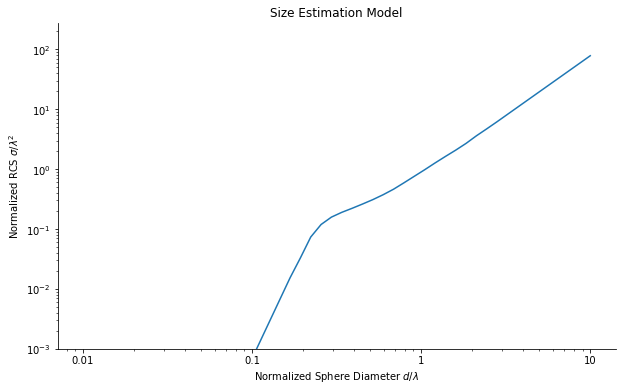

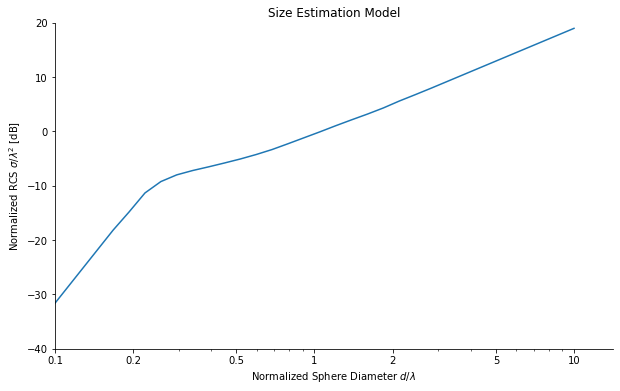

In [24]:
#@hidden_cell
# Generate the data

x = np.logspace(-2, 1)
z = radar.norm_diameter_to_norm_rcs(x)
z_db = 10*np.log10(z)

# Reproduce Fig. 3.2

formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, z)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(ymin=1e-3)
ax.set_xlabel('Normalized Sphere Diameter $d/\lambda$')
ax.set_ylabel('Normalized RCS $\sigma/\lambda^2$')
ax.set_title('Size Estimation Model')
ax.xaxis.set_major_formatter(formatter)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

# Reproduce Fig. 3.3

locator = LogLocator(base=10, subs=(0.2, 0.5, 1))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, z_db)
ax.set_xscale('log')
ax.set_xlim(xmin=0.1)
ax.set_ylim(ymin=-40, ymax=20)
ax.set_xlabel('Normalized Sphere Diameter $d/\lambda$')
ax.set_ylabel('Normalized RCS $\sigma/\lambda^2$ [dB]')
ax.set_title('Size Estimation Model')
ax.xaxis.set_major_formatter(formatter);
ax.xaxis.set_major_locator(locator)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

## Examining Some SSA Radars

Now that we know our model implementatation looks good, let's use it to explore the capabilities of some typical space surveillance radars. We'll start at the low frequencies and work our way up the frequency bands, calculating the RCS for a variety of sphere sizes. I put together a small spreadsheet of SSA radars. We'll cycle through a few of them and look at their operating characteristics.

In [25]:
df = pd.read_excel("radars.xlsx")
radar_list = ['GRAVE', 'Haystack', 'Cobra Dane', 'Eglin', 'TIRA (Ku)', 'HUSIR', 'Thoth Earthfence', 'LeoLabs KSR']
radars = df[df['Name'].isin(radar_list)].sort_values('Frequency (MHz)', ascending=False)
radars[['Name', 'Network', 'Frequency (MHz)', 'Band']]

,Name,Network,Frequency (MHz),Band
7,HUSIR,SSN,96000.00,W
15,TIRA (Ku),EU SST,16700.00,Ku
6,Haystack,SSN,10000.00,X
21,Thoth Earthfence,Thoth,5700.00,C
23,LeoLabs KSR,LeoLabs,2950.00,S
10,Cobra Dane,SSN,1300.00,L
11,Eglin,SSN,442.00,UHF
17,GRAVE,EU SST,143.05,VHF


Let's look at one of the classic SSA radars in particular, the US Space Force Space Surveillance Network (SSN) AN/FPS-85 radar at Eglin AFB, Florida, USA, operating at 422 MHz. Other radars operating at similar UHF frequencies include PARCS, Altair, the various PAVE PAWS/UEWR phased array radars, the EU's BIRALES, and the Poker Flats Incoherent Scatter Radar (PFISR).

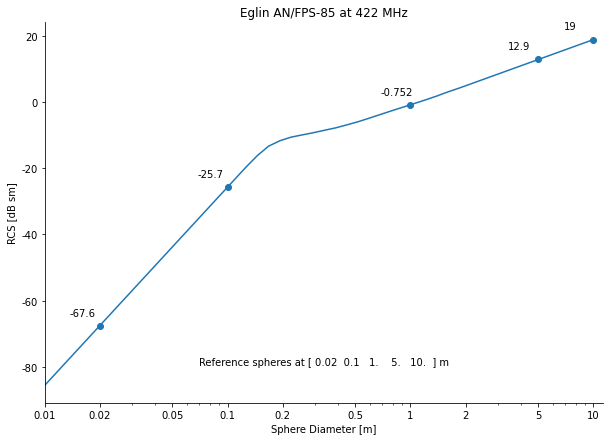

In [26]:
radar.plot_rcs(422e6, title='Eglin AN/FPS-85 at 422 MHz')
plt.savefig('eglin.png', dpi=300, facecolor='white')

We can see that it's performance really starts to fall off as we get to objects below 20 cm. Luckily it can compensate for this with power by operating at a peak transmit power as high as 32 MW (75 dBW)! Comparing that with the German TIRA radar operating in L-band which has a peak power of 2 MW (63 dBW).

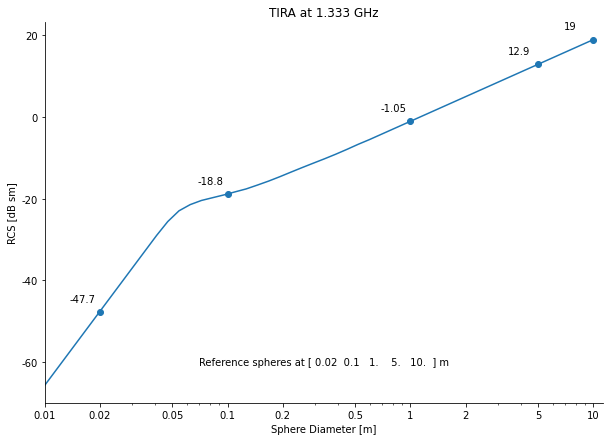

In [27]:
radar.plot_rcs(1330e6, title='TIRA at 1.333 GHz')

A 10 cm sphere tracked by Eglin has an RCS of -25.7 dBsm whereas TIRA would see it having an RCS of -18.8 dBsm. TIRA's higher frequency advantage gains it ~7dB of performance over Eglin, but Eglin can compensate with it's additional 12 dBW of power. Note that I'm ignoring all the other practical aspects of a radar such as the pulse width, duty cycle, number of pulses being integrated, the waveform that's used, how many targets are being tracked simultaneously, etc. These also come into play so it's not just a pure frequency vs. power trade-off.

We can overlay the individual curves for our set of SSA radars to produce a composite RCS plot. The individual lines are sorted in decreasing frequency order. The HUSIR, TIRA (in Ku-band mode), HAYSTACK, and Thoth Earthfence radars are all clearly operating in the optical (or near-optical) regime. Note that their primary purpose is not debris tracking, but rather imaging, for which the high frequency is even more important. 

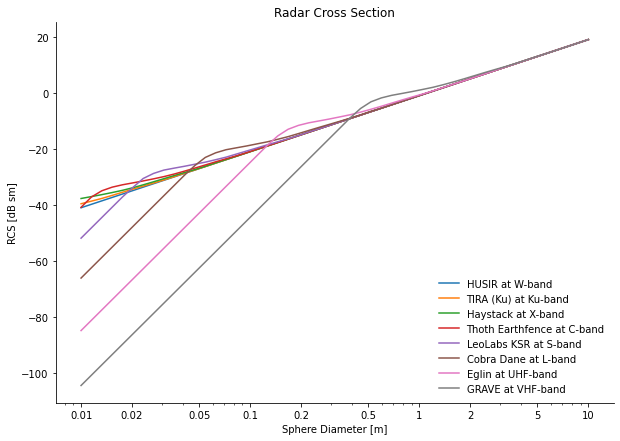

In [28]:
fig, ax = plt.subplots(figsize=(10,7))

# Default diameters range is 0.01 to 10 meters. We'll use these to 
# plot the background smooth curve.

diameter = np.logspace(-2, 1)
for i, r in radars.iterrows():
    frequency = r['Frequency (MHz)'] * 1e6
    rcs = 10*np.log10(radar.diameter_to_rcs(frequency, diameter))
    ax.plot(diameter, rcs, label=f"{r['Name']} at {r['Band']}-band")

locator = LogLocator(base=10, subs=(0.2, 0.5, 1))
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))

ax.set_xscale('log')
ax.set_xlabel('Sphere Diameter [m]')
ax.set_ylabel('RCS [dB sm]')
ax.set_title('Radar Cross Section')
ax.xaxis.set_major_formatter(formatter);
ax.xaxis.set_major_locator(locator)
    
ax.legend(loc='lower right', frameon=False)
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    
fig.savefig('multiple radars.png', dpi=300, facecolor='white')

We can examine how the RCS varies as a function of diameter and frequency by generating a heatmap over a range of frequencies. 

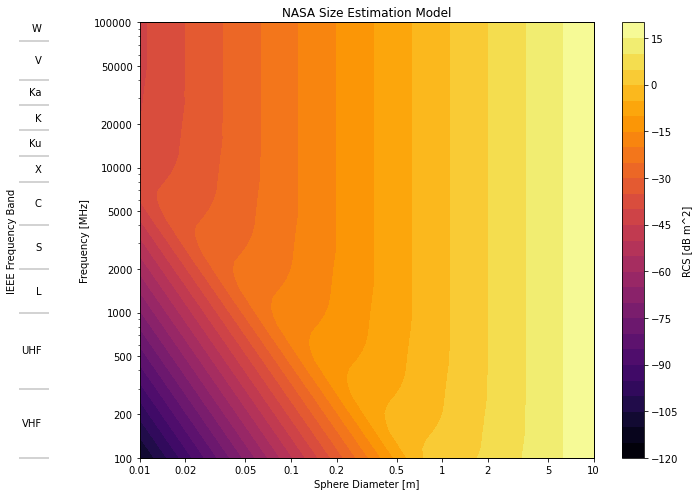

In [29]:
diameter = np.logspace(-2, 1, 50)
frequency_mhz = np.logspace(2, 5, 50)
frequency = frequency_mhz * 1e6

dv, fv = np.meshgrid(diameter, frequency)
rcs_db = 10*np.log10(radar.diameter_to_rcs(fv, dv))

# Plot the results
xlocator = LogLocator(base=10, subs=(0.2, 0.5, 1))
ylocator = LogLocator(base=10, subs=(0.2, 0.5, 1))
formatter = FuncFormatter(lambda x, _: '{:.16g}'.format(x))

db_contours = np.arange(-120, 25, step=5)
fig, ax = plt.subplots(figsize=(10,7))
cs = ax.contourf(diameter, frequency_mhz, rcs_db, levels=db_contours, cmap='inferno')
ax.set_xlabel('Sphere Diameter [m]')
ax.set_ylabel('Frequency [MHz]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(formatter);
ax.xaxis.set_major_locator(xlocator)
ax.yaxis.set_major_formatter(formatter);
ax.yaxis.set_major_locator(ylocator)
ax.set_title('NASA Size Estimation Model')
cb = fig.colorbar(cs)
cb.set_label('RCS [dB m^2]')

# now set up parallel axis for the frequency bands

freq_bands = ['VHF', 'UHF', 'L', 'S', 'C', 'X', 'Ku', 'K', 'Ka', 'V', 'W']
freq_ticks = [100, 300, 1000, 2000, 4000, 8000, 12000, 18000, 27000, 40000, 75000, 110000]

# calculate the mid-point of each band (in log scale) for drawing the labels
freq_log = np.log10(freq_ticks)
freq_mid = np.power(10, (freq_log[:-1] + freq_log[1:]) / 2)

axis_offset = -0.2
# Draw fat tick marks to delineate the frequency bands
ax_band_ticks = ax.twinx()
ax_band_ticks.spines['left'].set_position(('axes', axis_offset))
ax_band_ticks.set_yscale('log')
ax_band_ticks.set_yticks(freq_ticks)
ax_band_ticks.set_ylim(ymin=100, ymax=1e5)
ax_band_ticks.minorticks_off()
ax_band_ticks.yaxis.set_ticks_position('left')
ax_band_ticks.tick_params(axis='y', length=30, width=2, which='major', labelright=False, labelleft=False, color='lightgrey')
ax_band_ticks.spines['left'].set_visible(False)

# Draw the band identifiers in between the fat tick marks
ax_band = ax.twinx()
ax_band.spines['left'].set_position(('axes', axis_offset))
ax_band.set_ylabel('IEEE Frequency Band')
ax_band.set_ylim(ymin=100, ymax=1e5)
ax_band.set_yscale('log')
ax_band.set_yticks(freq_mid)
ax_band.set_yticklabels(freq_bands, fontdict={'verticalalignment':'center', 'horizontalalignment':'right'})
ax_band.tick_params(axis='y', which='both', right=False, left=False)
ax_band.minorticks_off()

ax_band.yaxis.set_ticks_position('left')
ax_band.yaxis.set_label_position('left')
ax_band.tick_params(left=False)
ax_band.spines['left'].set_visible(False)

fig.tight_layout()
fig.savefig(r'RCS Contour.png', bbox_inches='tight', facecolor='white', dpi=300)
fig.savefig(r'RCS Contour.svg', bbox_inches='tight')

In reality we can't use just any frequency we want as the usage is highly regulated by the International Telecommunications Union (ITU) and within the US the Federal Communications Commission (FCC). The FCC publishes a nice chart showing the frequency aallocations in the US [4] - search for the blocks marked "Radiolocation". Canada publishes a similar document [5]. 

Clearly there are advantages to using a higher frequency radar when we want to observe smaller objects. Of course, things aren't that simple - the complications around producing the relevant hardware and designs that can accomodate high frequency operations become quite the challenge both physically and financially. Currently most operators are concerned with objects that are >2 cm in size, thus the recent focus on building radars that operate in L or S band.

# References

[1] "Haystack and HAX Radar Measurements of the Orbital Debris Environment; 2003", Section 4.0.  https://www.orbitaldebris.jsc.nasa.gov/library/haystack_hax_radar2003.pdf

[2] "Final Report of the Haystack Orbital Debris Data Review Panel", Technical Memorandum 4809, NASA, February 1998. See section 3.2.

[3] "Haystack and HAX Radar Measurements of the Orbital Debris Environment: 2006-2012", Section 4.2. 

[4] "United States Frequency Allocations", U.S. Department of Commerce, National Telecommunications and Information Administration, Office of Spectrum Management, October 2003, https://www.ntia.doc.gov/files/ntia/publications/2003-allochrt.pdf

[5] "Radio Spectrum Allocations in Canada" https://www.ic.gc.ca/eic/site/smt-gst.nsf/vwapj/2018_Canadian_Radio_Spectrum_Chart.PDF/$FILE/2018_Canadian_Radio_Spectrum_Chart.PDF